In [1]:
import numpy as np
import pandas as pd
import zipfile
from pathlib import Path

# Extract all zip files in 'data/btc' folder
data_path = Path("../../data/btc")
# i = 0
# for file in data_path.glob('*.zip'):
#     with zipfile.ZipFile(file, 'r') as zip_ref:
#         zip_ref.extractall(data_path)
#     i += 1
#
#     if i > 2:
#         break

# Read all CSV files and concatenate into a single DataFrame
csv_files = list(data_path.glob("bitstamp_ob*.csv"))
df = pd.concat((pd.read_csv(csv_file) for csv_file in csv_files), ignore_index=True)

# Display the head of the resulting DataFrame
df.head()

,time,type,price,amount
0,1534197602,b,6236.82,0.079600
1,1534197602,b,6236.79,0.040085
2,1534197602,b,6236.78,2.402200
3,1534197602,b,6235.02,0.040100
4,1534197602,b,6235.00,1.000000


In [2]:
timestamps = df["time"].unique()
snapshot_data = df[df["time"] == timestamps[0]]
snapshot_data

,time,type,price,amount
0,1534197602,b,6236.82,0.079600
1,1534197602,b,6236.79,0.040085
2,1534197602,b,6236.78,2.402200
3,1534197602,b,6235.02,0.040100
4,1534197602,b,6235.00,1.000000
...,...,...,...,...
8118,1534197602,a,13510.56,0.015100
8119,1534197602,a,13511.00,1.700000
8120,1534197602,a,13527.00,0.020000
8121,1534197602,a,13529.44,0.001294


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orderbook(snapshot: pd.DataFrame, n_drop_bids: int | None = None, n_drop_asks: int | None = None):
    ask_price = snapshot[snapshot["type"] == "a"]["price"].to_numpy()
    ask_qty = snapshot[snapshot["type"] == "a"]["amount "].to_numpy()

    bid_price = snapshot[snapshot["type"] == "b"]["price"].to_numpy()
    bid_qty = snapshot[snapshot["type"] == "b"]["amount "].to_numpy()

    ask_df = pd.DataFrame({'price': ask_price, 'quantity': ask_qty})
    bid_df = pd.DataFrame({'price': bid_price, 'quantity': bid_qty})

    if n_drop_bids is not None:
        bid_df = bid_df.iloc[:-n_drop_bids]

    if n_drop_asks is not None:
        ask_df = ask_df.iloc[:-n_drop_asks]

    fig, ax = plt.subplots()
    ax.set_title(f"Order Book Depth Chart")
    sns.ecdfplot(x="price", weights="quantity", stat="count",
                 data=ask_df, ax=ax, color="red")
    sns.ecdfplot(x="price", weights="quantity", stat="count",
                    complementary=True, data=bid_df, ax=ax, color="green")
    # complementary=True allows reflects that lower bids are "better"
    ax.set_xlabel("Price")
    ax.set_ylabel("Quantity")

    plt.show()

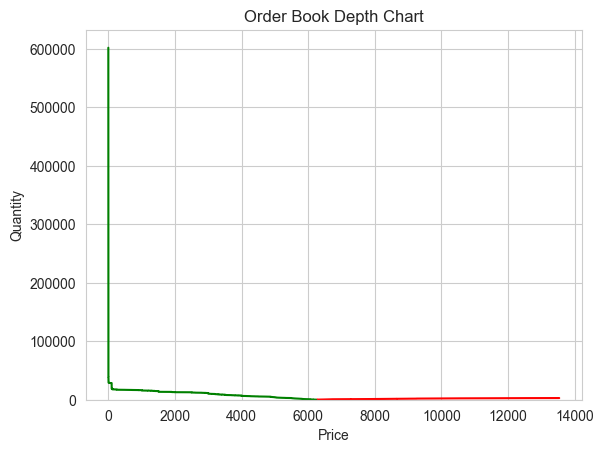

In [4]:
plot_orderbook(snapshot_data)

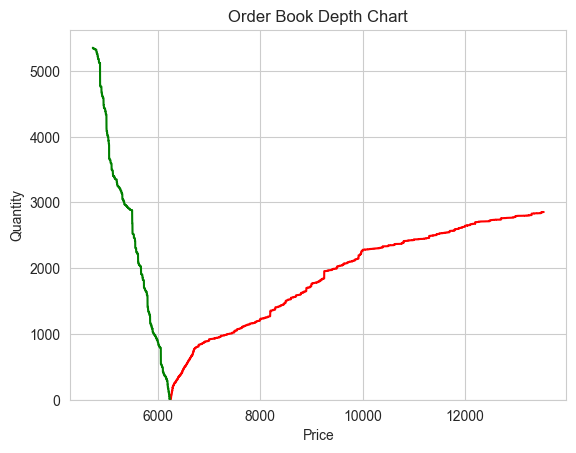

In [5]:
plot_orderbook(snapshot_data, n_drop_bids=int(snapshot_data.shape[0] * 0.20))

In [6]:
df["time"].nunique()

311906

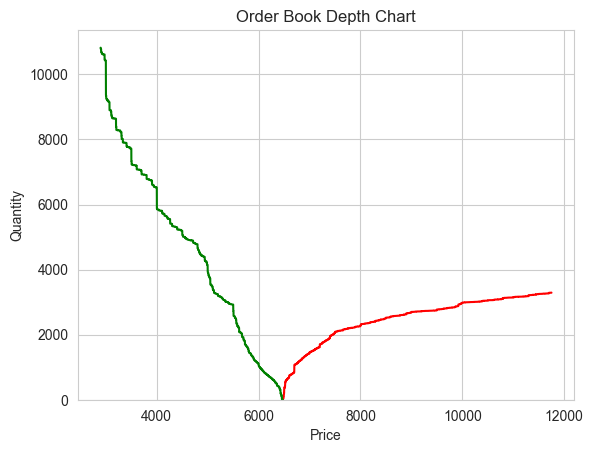

In [7]:
snapshot_data = df[df["time"] == timestamps[5000]]

plot_orderbook(snapshot_data, n_drop_bids=int(snapshot_data.shape[0] * 0.10), n_drop_asks=int(snapshot_data.shape[0] * 0.10))

In [8]:
class OrderBookFeatures:
    def __init__(self) -> None:
        pass

    @staticmethod
    def get_volumes(
        orderbook: pd.DataFrame,
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        bid_volume = (
            orderbook[orderbook["type"] == "b"]
            .groupby("time", as_index=False)
            .sum()
            .set_index("time")["amount "]
            .rename("bid_volume")
        )
        ask_volume = (
            orderbook[orderbook["type"] == "a"]
            .groupby("time", as_index=False)
            .sum()
            .set_index("time")["amount "]
            .rename("ask_volume")
        )
        volume_diff = (ask_volume - bid_volume).rename("volume_diff")

        return ask_volume, bid_volume, volume_diff

    @staticmethod
    def get_spread(orderbook: pd.DataFrame) -> pd.DataFrame:
        highest_buy = (
            orderbook[orderbook["type"] == "b"].groupby("time", as_index=False).max()
        )
        lowest_sell = (
            orderbook[orderbook["type"] == "a"].groupby("time", as_index=False).min()
        )
        spread = (
            lowest_sell.set_index("time")["price"]
            - highest_buy.set_index("time")["price"]
        )
        spread = spread.rename("spread")
        return spread

    @staticmethod
    def get_orders(
        orderbook: pd.DataFrame,
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        bid_orders = (
            orderbook[orderbook["type"] == "b"]
            .groupby("time", as_index=False)
            .count()
            .set_index("time")["price"]
            .rename("bid_depth")
        )
        ask_orders = (
            orderbook[orderbook["type"] == "a"]
            .groupby("time", as_index=False)
            .count()
            .set_index("time")["price"]
            .rename("ask_depth")
        )
        depth_diff = (ask_orders - bid_orders).rename("depth_diff")
        return ask_orders, bid_orders, depth_diff

    @staticmethod
    def get_weighted_spread(orderbook: pd.DataFrame) -> pd.DataFrame:
        def get_cumulative_amount(group, order_type):
            group = group.sort_values(
                ["price"], ascending=False if order_type == "b" else True
            )
            total_amount = group["amount "].sum()
            threshold = total_amount * 0.1
            cumulative_amount = 0
            for _, row in group.iterrows():
                cumulative_amount += row["amount "]
                if cumulative_amount >= threshold:
                    return cumulative_amount
            return np.nan

        top_10_bid = (
            orderbook[orderbook["type"] == "b"]
            .sort_values(["time"], ascending=True)
            .groupby("time", as_index=False)
            .apply(lambda group: get_cumulative_amount(group, "b"))
        )
        top_10_bid = top_10_bid.set_index("time")
        top_10_bid.columns.values[0] = "bid_amount"

        top_10_ask = (
            orderbook[orderbook["type"] == "a"]
            .sort_values(["time"], ascending=True)
            .groupby("time", as_index=False)
            .apply(lambda group: get_cumulative_amount(group, "a"))
        )
        top_10_ask = top_10_ask.set_index("time")
        top_10_ask.columns.values[0] = "ask_amount"

        return (top_10_bid.iloc[:, 0] - top_10_ask.iloc[:, 0]).rename("weighted_spread")

    @staticmethod
    def get_slopes(orderbook: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        def get_cumulative_price(group, order_type):
            group = group.sort_values(
                ["price"], ascending=False if order_type == "b" else True
            )
            total_amount = group["amount "].sum()
            threshold = total_amount * 0.1
            cumulative_amount = 0
            for _, row in group.iterrows():
                cumulative_amount += row["amount "]
                if cumulative_amount >= threshold:
                    return row["price"]
            return np.nan

        top_10_bid = (
            orderbook[orderbook["type"] == "b"]
            .sort_values(["time"], ascending=True)
            .groupby("time", as_index=False)
            .apply(lambda group: get_cumulative_price(group, "b"))
        )
        top_10_bid = top_10_bid.set_index("time")
        top_10_bid.columns.values[0] = "bid_slope"

        top_10_ask = (
            orderbook[orderbook["type"] == "a"]
            .sort_values(["time"], ascending=True)
            .groupby("time", as_index=False)
            .apply(lambda group: get_cumulative_price(group, "a"))
        )
        top_10_ask = top_10_ask.set_index("time")
        top_10_ask.columns.values[0] = "ask_slope"

        return top_10_ask, top_10_bid

    def get_features(self, orderbook: pd.DataFrame) -> pd.DataFrame:
        spread = self.get_spread(orderbook)
        ask_depth, bid_depth, depth_diff = self.get_orders(orderbook)
        ask_volume, bid_volume, volume_diff = self.get_volumes(orderbook)
        ws = self.get_weighted_spread(orderbook)
        ask_slope, bid_slope = self.get_slopes(orderbook)
        features = pd.concat(
            [
                spread,
                ask_depth,
                bid_depth,
                depth_diff,
                ask_volume,
                bid_volume,
                volume_diff,
                ws,
                ask_slope,
                bid_slope,
            ],
            axis=1,
        )
        features.index = pd.to_datetime(features.index, unit="s")
        return features

    def __call__(self, orderbook: pd.DataFrame) -> pd.DataFrame:
        return self.get_features(orderbook)

In [9]:
df

,time,type,price,amount
0,1534197602,b,6236.82,0.079600
1,1534197602,b,6236.79,0.040085
2,1534197602,b,6236.78,2.402200
3,1534197602,b,6235.02,0.040100
4,1534197602,b,6235.00,1.000000
...,...,...,...,...
2634980387,1534888774,a,13843.00,0.087000
2634980388,1534888774,a,13846.00,0.081000
2634980389,1534888774,a,13846.11,0.018385
2634980390,1534888774,a,13847.00,0.020000


In [10]:
# Define a function to process the DataFrame
def process_orderbook(df, thr: float = 0.20):
    def filter_orderbook(group):
        # Get bids and asks
        bids = group[group["type"] == "b"]
        asks = group[group["type"] == "a"]

        # Calculate thresholds
        bid_threshold = bids["price"].quantile(thr) if not bids.empty else None
        ask_threshold = asks["price"].quantile(1 - thr) if not asks.empty else None

        # Filter out the lowest 10% of bids
        bids_filtered = bids[bids["price"] > bid_threshold] if bid_threshold else bids

        # Filter out the highest 10% of asks
        asks_filtered = asks[asks["price"] < ask_threshold] if ask_threshold else asks

        # Combine filtered bids and asks
        return pd.concat([bids_filtered, asks_filtered])

    # Apply the filtering function on each group of "time"
    df_filtered = df.groupby("time", group_keys=False).apply(filter_orderbook)

    return df_filtered


# Apply the function to your DataFrame
df_filtered = process_orderbook(df)

/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_8689/1841676509.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby("time", group_keys=False).apply(filter_orderbook)


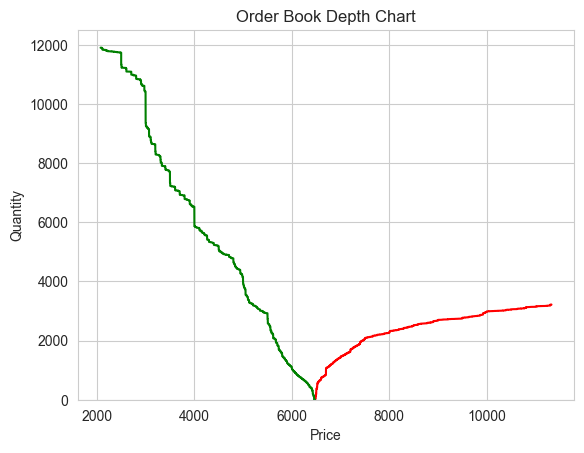

In [11]:
snapshot_data = df_filtered[df_filtered["time"] == timestamps[5000]]

plot_orderbook(snapshot_data)

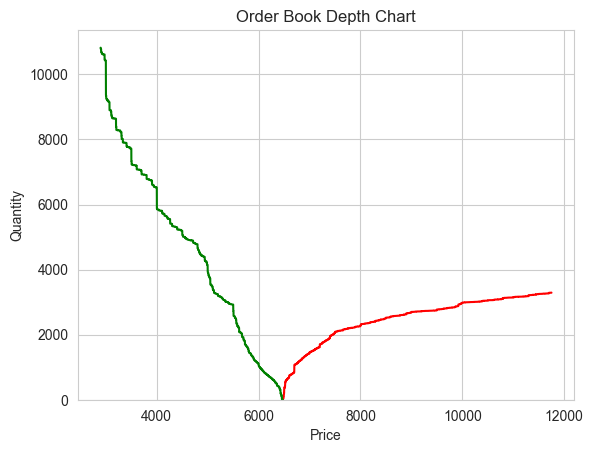

In [12]:
snapshot_data = df[df["time"] == timestamps[5000]]

plot_orderbook(snapshot_data, n_drop_bids=int(snapshot_data.shape[0] * 0.10), n_drop_asks=int(snapshot_data.shape[0] * 0.10))

In [13]:
obf = OrderBookFeatures()
features = obf(df_filtered)
features

/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_8689/3514484096.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: get_cumulative_amount(group, "b"))
/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_8689/3514484096.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: get_cumulative_amount(group, "a"))
/var/folders/sr/lzvmv9j54ks_jl4x99t250r000

,spread,ask_depth,bid_depth,depth_diff,ask_volume,bid_volume,volume_diff,weighted_spread,ask_slope,bid_slope
time,,,,,,,,,,
2018-06-04 22:00:02,6.19,4000,2808,1192,2288.215849,12731.737072,-10443.521223,1051.578710,7581.61,6964.01
2018-06-04 22:00:34,6.19,4000,2808,1192,2288.534415,12726.892780,-10438.358364,1045.915353,7581.61,6964.01
2018-06-04 22:01:01,4.97,4000,2808,1192,2291.262389,12726.561460,-10435.299071,1047.082641,7581.03,6964.01
2018-06-04 22:01:33,4.96,4000,2806,1194,2249.345384,12682.978896,-10433.633512,1045.631341,7587.31,6929.32
2018-06-04 22:02:02,4.90,4000,2807,1193,2249.919150,12693.220325,-10443.301176,1041.502402,7587.07,6945.00
...,...,...,...,...,...,...,...,...,...,...
2018-09-30 21:57:34,1.58,4000,2836,1164,2577.148039,11880.676125,-9303.528086,962.447407,6618.00,6060.00
2018-09-30 21:58:01,1.59,4000,2833,1167,2548.567998,11861.303882,-9312.735884,954.261985,6618.00,6060.00
2018-09-30 21:58:34,0.76,4000,2834,1166,2550.397300,11855.965324,-9305.568024,947.094124,6618.00,6060.00


In [14]:
snapshot = df[df["time"] == 1534197602]
bids = snapshot[snapshot["type"] == "b"]
bids["cum_vol"] = bids["amount "].cumsum()
bids["p_vol"] = bids["cum_vol"] / bids["amount "].sum()
bids

/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_8689/3661847083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bids["cum_vol"] = bids["amount "].cumsum()
/var/folders/sr/lzvmv9j54ks_jl4x99t250r00000gn/T/ipykernel_8689/3661847083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bids["p_vol"] = bids["cum_vol"] / bids["amount "].sum()


,time,type,price,amount,cum_vol,p_vol
0,1534197602,b,6236.82,0.079600,0.079600,1.322102e-07
1,1534197602,b,6236.79,0.040085,0.119685,1.987880e-07
2,1534197602,b,6236.78,2.402200,2.521885,4.188679e-06
3,1534197602,b,6235.02,0.040100,2.561985,4.255282e-06
4,1534197602,b,6235.00,1.000000,3.561985,5.916214e-06
...,...,...,...,...,...,...
3118,1534197602,b,0.05,10500.000000,288218.621986,4.787115e-01
3119,1534197602,b,0.04,1000.000000,289218.621986,4.803724e-01
3120,1534197602,b,0.03,12500.000000,301718.621986,5.011341e-01
3121,1534197602,b,0.02,71479.000000,373197.621986,6.198558e-01


In [15]:
features = features.sort_index(ascending=True)
features.to_csv("../../data/btc/features.csv")

In [16]:
# df.to_csv('../../data/btc/df.csv')

In [17]:
ask_orders = (
    df[df["type"] == "a"]
    .groupby("time", as_index=False)
    .count()
    .set_index("time")["price"]
    .rename("ask_depth")
)
ask_orders.unique()

array([  5000,  85000,  10000,  30000, 130000, 135000,  20000,  15000])

In [18]:
csv_files

[PosixPath('../../data/btc/bitstamp_ob_14_08_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_14_09_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_16_07_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_16_06_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_08_08_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_08_09_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_24_07_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_24_06_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_26_08_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_26_09_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_31_07_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_18_09_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_18_08_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_28_06_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_28_07_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_06_06_2018.csv'),
 PosixPath('../../data/btc/bitstamp_ob_06_07_2018.csv'),
 PosixPath('../../data/btc/bits

In [19]:
df["time"].min(), df["time"].max()

(np.int64(1528149602), np.int64(1538344773))